### 人工智能大模型应用作业

In [3]:
import pandas as pd
import os, requests, json
from openai import OpenAI
from tqdm import tqdm

### 1.提取各年报M&A数据

In [2]:
! python app/extract_mda.py

🔧 启动多进程提取，并行数：15

📂 处理目录: 2024_5405份 (共 5405 份)
✅ 完成：成功 5400, 失败 0, 跳过 5



2024进度: 100%|██████████| 5405/5405 [00:04<00:00, 1279.03it/s]


### 2.扩展关键词表
- 由于模型内存较大，在云端服务器运行，因此插入运行结果图片

In [ ]:
# 运行扩展关键词脚本
# topn表示每个种子词扩展出的关键词数量，min_sim表示扩展关键词与种子词的最小相似度
! python expand_w2v_tencent.py --seeds keywords.json --use-tencent --topn 10 --min_sim 0.8 --excel keywords_expand.xlsx

### 3.进一步提取文本中有关风险的句子&数据清洗

In [12]:
# 运行风险句子抽取脚本
! python app/extract_hits.py \
  --dict data/keywords/keywords_expand.xlsx \
  --annual_dir "data\output\2024_5405份" \
  --out data/output/climaterisk_hits_2024.csv

[SCANNING 2024] 2024_5405份...
  -> 发现 2303584 条匹配

[DONE] 2024年匹配完成！结果保存至: E:\projects\risk-pipeline\data\output\climaterisk_hits_2024.csv
总计命中句数: 2303584


In [31]:
# ======== 配置路径 ========
input_file = r'E:\projects\risk-pipeline\data\output\climaterisk_hits_2024.csv'
output_file = r'E:\projects\risk-pipeline\data\output\climaterisk_final_sample.csv'

def process_and_sample(path, save_path, sample_size=10000):
    print("开始处理 2024 年风险数据...")
    df = pd.read_csv(path, encoding='utf-8-sig')
    
    # 1. 物理去重：删除同一公司、同一类别的完全重复句子
    # 避免因关键词重叠或脚本重复运行产生的冗余
    df.drop_duplicates(subset=['股票代码', '句子', '二级分类'], inplace=True)
    
    # 2. 语义质量过滤：去除长度异常的句子
    # 太短（<20字）通常缺乏语境；太长（>300字）可能是格式解析错误或无意义长句
    df = df[df['句子'].str.len().between(20, 300)]
    
    # 3. 模板化噪声剔除：删除全市场出现次数过高（>50次）的句子
    # 2024年年报中大量出现的“积极响应双碳号召”等口号属于典型的模板化披露（Boilerplate）
    vague_counts = df['句子'].value_counts()
    vague_list = vague_counts[vague_counts > 50].index
    df = df[~df['句子'].isin(vague_list)]
    
    # 4. 行业分层抽样 (Stratified Sampling)：确保物理风险、转型风险、机遇数据均衡
    # 为了后续对比 FinBERT 与 LLM 在不同类别上的表现
    df_final = df.groupby('二级分类', group_keys=False).apply(
        lambda x: x.sample(min(len(x), sample_size), random_state=42)
    )
    
    print(f"原始数据: {len(vague_counts)} 条句子匹配")
    print(f"最终精选样本: {len(df_final)} 条")
    
    # 保存结果
    df_final.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"✅ 处理完成，样本已保存至: {save_path}")

if __name__ == "__main__":
    process_and_sample(input_file, output_file)

开始处理 2024 年风险数据...


C:\Users\vermouth\AppData\Local\Temp\ipykernel_31652\2118542497.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df.groupby('二级分类', group_keys=False).apply(


原始数据: 1098302 条句子匹配
最终精选样本: 30000 条
✅ 处理完成，样本已保存至: E:\projects\risk-pipeline\data\output\climaterisk_final_sample.csv


### 4.标注与分析

#### 4.1 词频分析

In [25]:
# ======== 路径配置 ========
# 输入：去重抽样后的精选样本
input_sample = r'E:\projects\risk-pipeline\data\output\climaterisk_final_sample.csv'
# 输出：企业层面的词频暴露得分表
output_score = r'E:\projects\risk-pipeline\data\output\fcre_dictionary_scores_2024.csv'

def calculate_dictionary_fcre(path, save_path):
    print("🚀 正在执行词频法风险测度 (Baseline)...")
    
    # 1. 加载数据
    df = pd.read_csv(path, encoding='utf-8-sig')
    
    # 2. 计算各分类下的词频得分
    # 在本实验中，每一行代表命中一个关键词的句子
    # 我们按公司（股票代码）和分类汇总句数
    fcre_counts = df.groupby(['股票代码', '公司', '一级分类', '二级分类']).size().reset_index(name='词频得分')
    
    # 3. 矩阵透视：将二级分类转为列，方便后续计量分析
    # 这样可以得到每个公司在“物理风险”、“转型风险”、“气候机遇”的具体得分
    fcre_pivot = fcre_counts.pivot_table(
        index=['股票代码', '公司'], 
        columns='二级分类', 
        values='词频得分', 
        fill_value=0
    ).reset_index()
    
    # 4. 计算总暴露指数 (ClimateRisk_i,t)
    # 此处简化为风险句加总
    risk_cols = [col for col in fcre_pivot.columns if '风险' in col]
    fcre_pivot['总风险得分'] = fcre_pivot[risk_cols].sum(axis=1)
    
    # 5. 保存结果
    fcre_pivot.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"✅ 词频法测度完成！共计算 {len(fcre_pivot)} 家公司。")
    return fcre_pivot

if __name__ == "__main__":
    scores_df = calculate_dictionary_fcre(input_sample, output_score)
    print(scores_df.head())

🚀 正在执行词频法风险测度 (Baseline)...
✅ 词频法测度完成！共计算 3586 家公司。
二级分类  股票代码    公司  气候机遇  物理风险  转型风险  总风险得分
0        1  平安银行   1.0   1.0   1.0    2.0
1        2   万科A   1.0   0.0   1.0    1.0
2        4  国华网安   4.0   0.0   3.0    3.0
3        6  深振业A   0.0   0.0   2.0    2.0
4        7   全新好   1.0   3.0   2.0    5.0


#### 4.2 finbert2

In [ ]:
! python app\Finbert_analysis.py

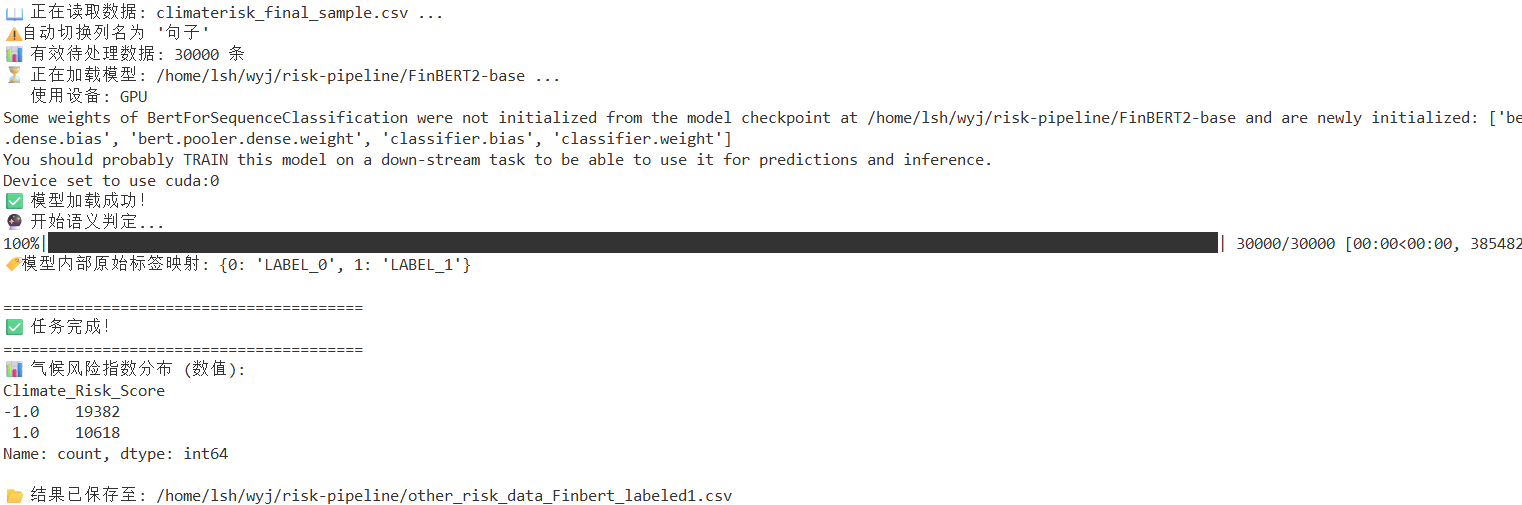

#### 4.3 DeepSeek分析

In [ ]:
#500样本
! python app\llm_analysis.py --model deepseek

🌟 正在初始化。模式: deepseek | 抽样数: 500

✅ 处理完成！结果已保存至: E:\projects\risk-pipeline\data\output\climaterisk_LLM_Final_Labeled.csv
📊 标签分布:
LLM_Label
 0    450
 1     28
-1     22
Name: count, dtype: int64



使用 deepseek-chat 标注中: 100%|██████████| 500/500 [31:32<00:00,  3.78s/it]


In [ ]:
#全量分析（在服务器端完成）
! python app\llm_analysis.py --model deepseek

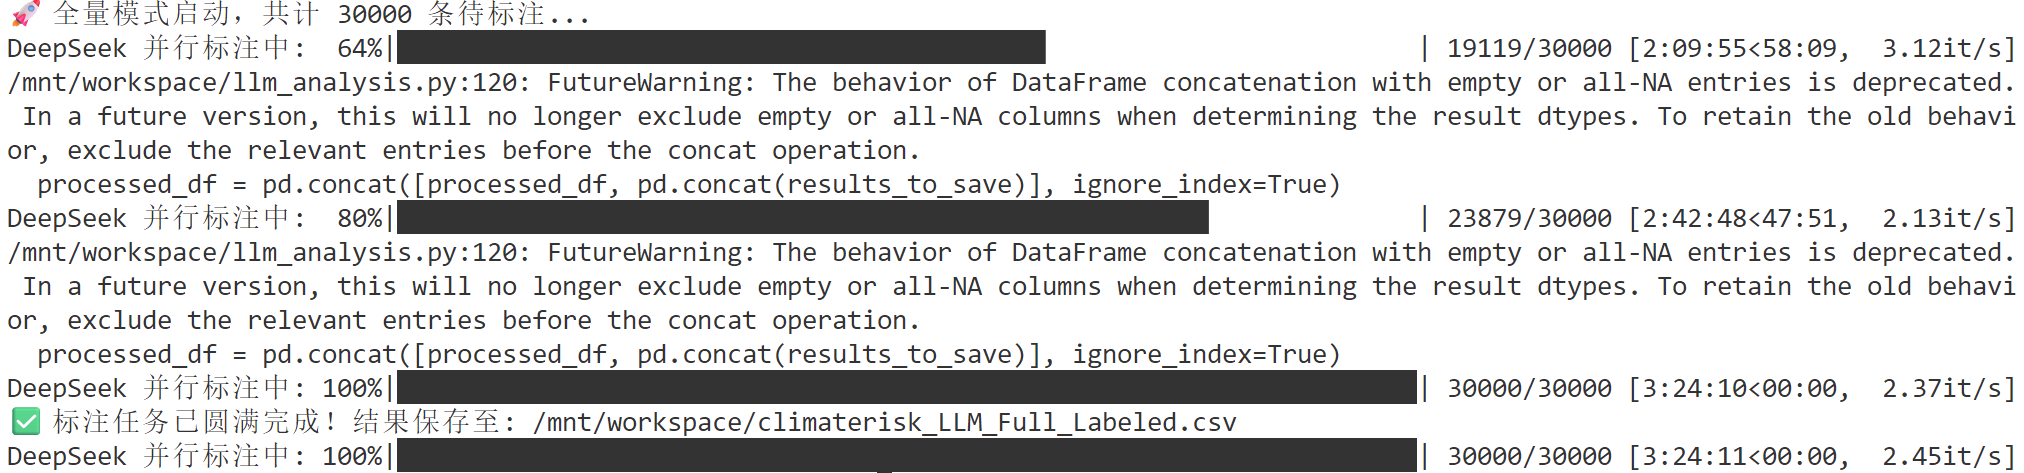

### 5.结果分析

#### 5.1分布状态

C:\Users\vermouth\AppData\Local\Temp\ipykernel_31652\1484312406.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt, x='风险类型', y='得分', palette="Set2", showfliers=True, ax=axes[0, 1])


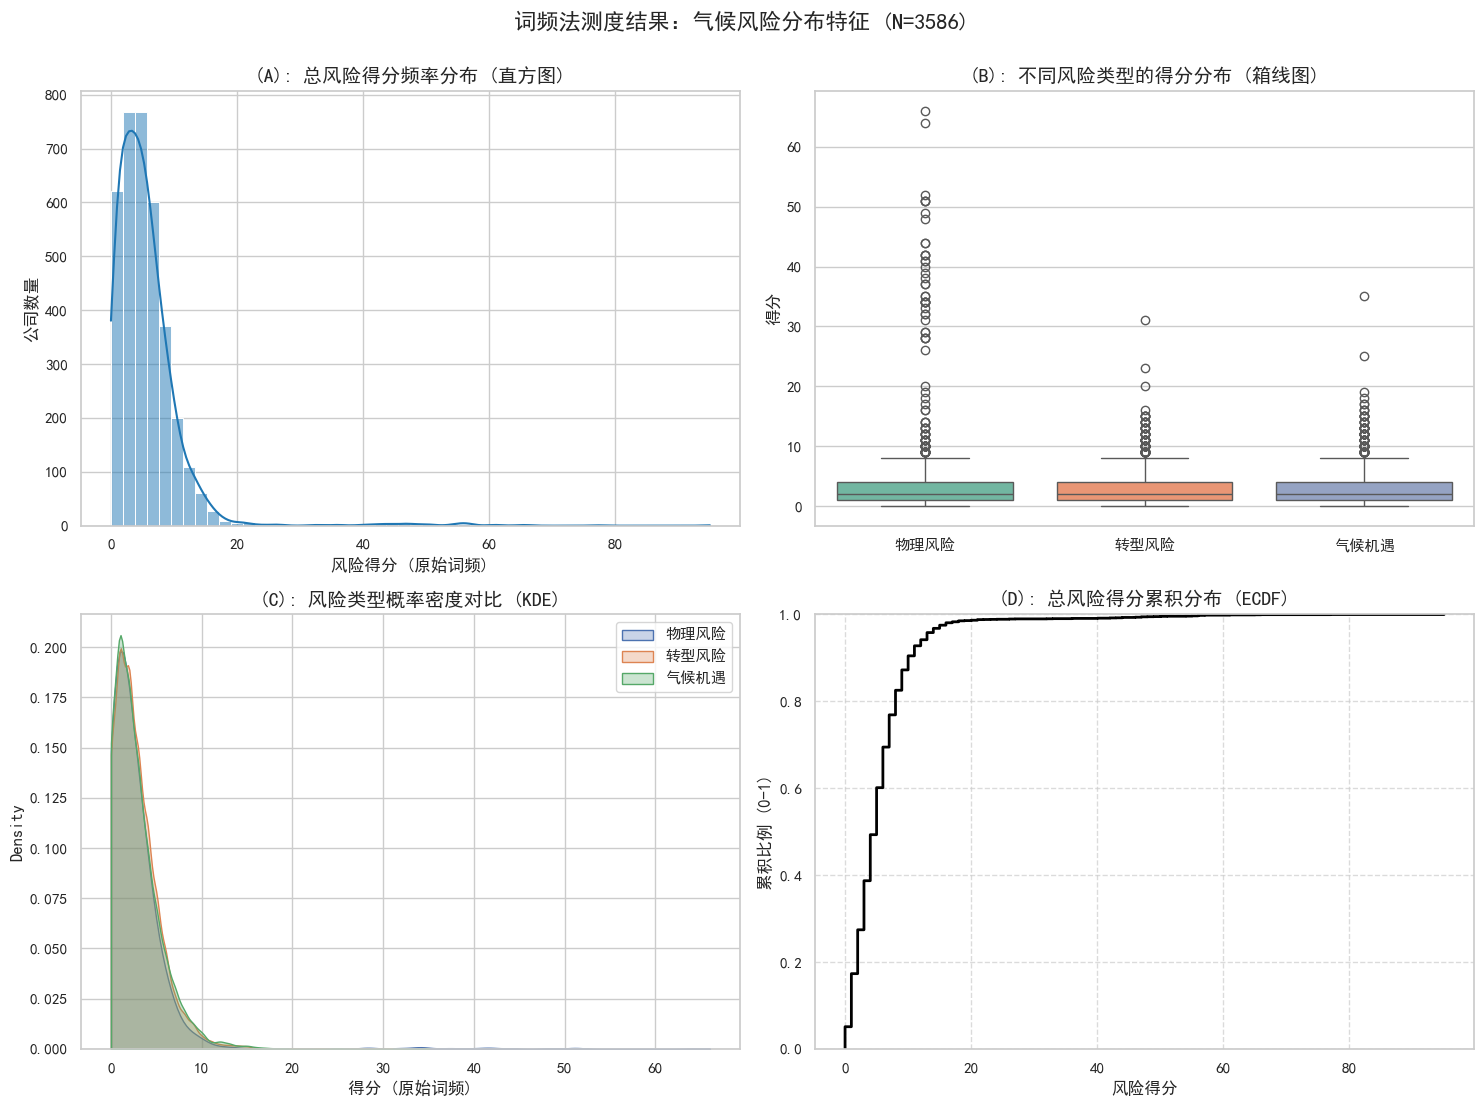


=== 原始词频(未取对数)的描述性统计结果 ===
        count      mean       std  min  25%  50%  75%   max  偏度(Skew)  \
二级分类                                                                    
物理风险   3586.0  2.788622  4.471006  0.0  1.0  2.0  4.0  66.0  7.022018   
转型风险   3586.0  2.788622  2.506437  0.0  1.0  2.0  4.0  31.0  1.860325   
气候机遇   3586.0  2.788622  2.660721  0.0  1.0  2.0  4.0  35.0  2.092077   
总风险得分  3586.0  5.577245  6.068992  0.0  2.0  5.0  7.0  95.0  5.491892   

        峰度(Kurt)  
二级分类              
物理风险   66.089457  
转型风险    8.264004  
气候机遇   10.290135  
总风险得分  47.586294  


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. 准备数据
# ==========================================
# 假设 df 是您原始的词频统计结果
# 直接复制，不进行 np.log1p 处理
df_result = scores_df.copy() 

# 直接计算原始词频的总和
df_result['总风险得分'] = df_result['物理风险'] + df_result['转型风险']

# ==========================================
# 2. 设置绘图风格与中文字体
# ==========================================
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # Windows系统
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 3. 绘制组合图 (原始数据版)
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('词频法测度结果：气候风险分布特征 (N=3586)', fontsize=16, y=0.95)

# --- 图1：总风险得分的频率分布直方图 ---
# 注意：由于原始数据跨度大，bin的数量可能需要调整，或者图会很偏
sns.histplot(data=df_result, x='总风险得分', kde=True, bins=50, color='#1f77b4', ax=axes[0, 0])
axes[0, 0].set_title('(A): 总风险得分频率分布 (直方图)', fontsize=14)
axes[0, 0].set_xlabel('风险得分 (原始词频)')
axes[0, 0].set_ylabel('公司数量')

# --- 图2：三大类风险的箱线图对比 ---
df_melt = df_result.melt(value_vars=['物理风险', '转型风险', '气候机遇'], var_name='风险类型', value_name='得分')
# showfliers=False 可以隐藏极端的异常值点，否则箱子会被压缩得很扁
sns.boxplot(data=df_melt, x='风险类型', y='得分', palette="Set2", showfliers=True, ax=axes[0, 1])
axes[0, 1].set_title('(B): 不同风险类型的得分分布 (箱线图)', fontsize=14)
axes[0, 1].set_xlabel('')

# --- 图3：核密度估计曲线对比 ---
# cut=0 表示截断负数部分的拟合（因为词频不能为负）
sns.kdeplot(data=df_result, x='物理风险', fill=True, label='物理风险', alpha=0.3, cut=0, ax=axes[1, 0])
sns.kdeplot(data=df_result, x='转型风险', fill=True, label='转型风险', alpha=0.3, cut=0, ax=axes[1, 0])
sns.kdeplot(data=df_result, x='气候机遇', fill=True, label='气候机遇', alpha=0.3, cut=0, ax=axes[1, 0])
axes[1, 0].set_title('(C): 风险类型概率密度对比 (KDE)', fontsize=14)
axes[1, 0].set_xlabel('得分 (原始词频)')
axes[1, 0].legend()

# --- 图4：累积分布函数 (ECDF) ---
sns.ecdfplot(data=df_result, x='总风险得分', label='总风险', color='black', linewidth=2, ax=axes[1, 1])
axes[1, 1].set_title('(D): 总风险得分累积分布 (ECDF)', fontsize=14)
axes[1, 1].set_xlabel('风险得分')
axes[1, 1].set_ylabel('累积比例 (0-1)')
axes[1, 1].grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ==========================================
# 4. 输出描述性统计表
# ==========================================
stats_table = df_result[['物理风险', '转型风险', '气候机遇', '总风险得分']].describe().T
stats_table['偏度(Skew)'] = df_result[['物理风险', '转型风险', '气候机遇', '总风险得分']].skew()
stats_table['峰度(Kurt)'] = df_result[['物理风险', '转型风险', '气候机遇', '总风险得分']].kurt()

print("\n=== 原始词频(未取对数)的描述性统计结果 ===")
print(stats_table)

In [48]:
df2 = pd.read_csv(r'E:\projects\risk-pipeline\data\risk_Finbert_labeled.csv', encoding='utf-8-sig')
print(df2.columns)

Index(['文件名', '股票代码', '年份', '公司', '句序', '一级分类', '二级分类', '命中关键词', '句子',
       'AI_Label_Text', 'Climate_Risk_Score', 'AI_Confidence'],
      dtype='object')


In [ ]:
df2.head(5)

C:\Users\vermouth\AppData\Local\Temp\ipykernel_31652\1696775465.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df2, x='AI_Label_Text', y='AI_Confidence', palette='Set2', ax=axes[0, 1])


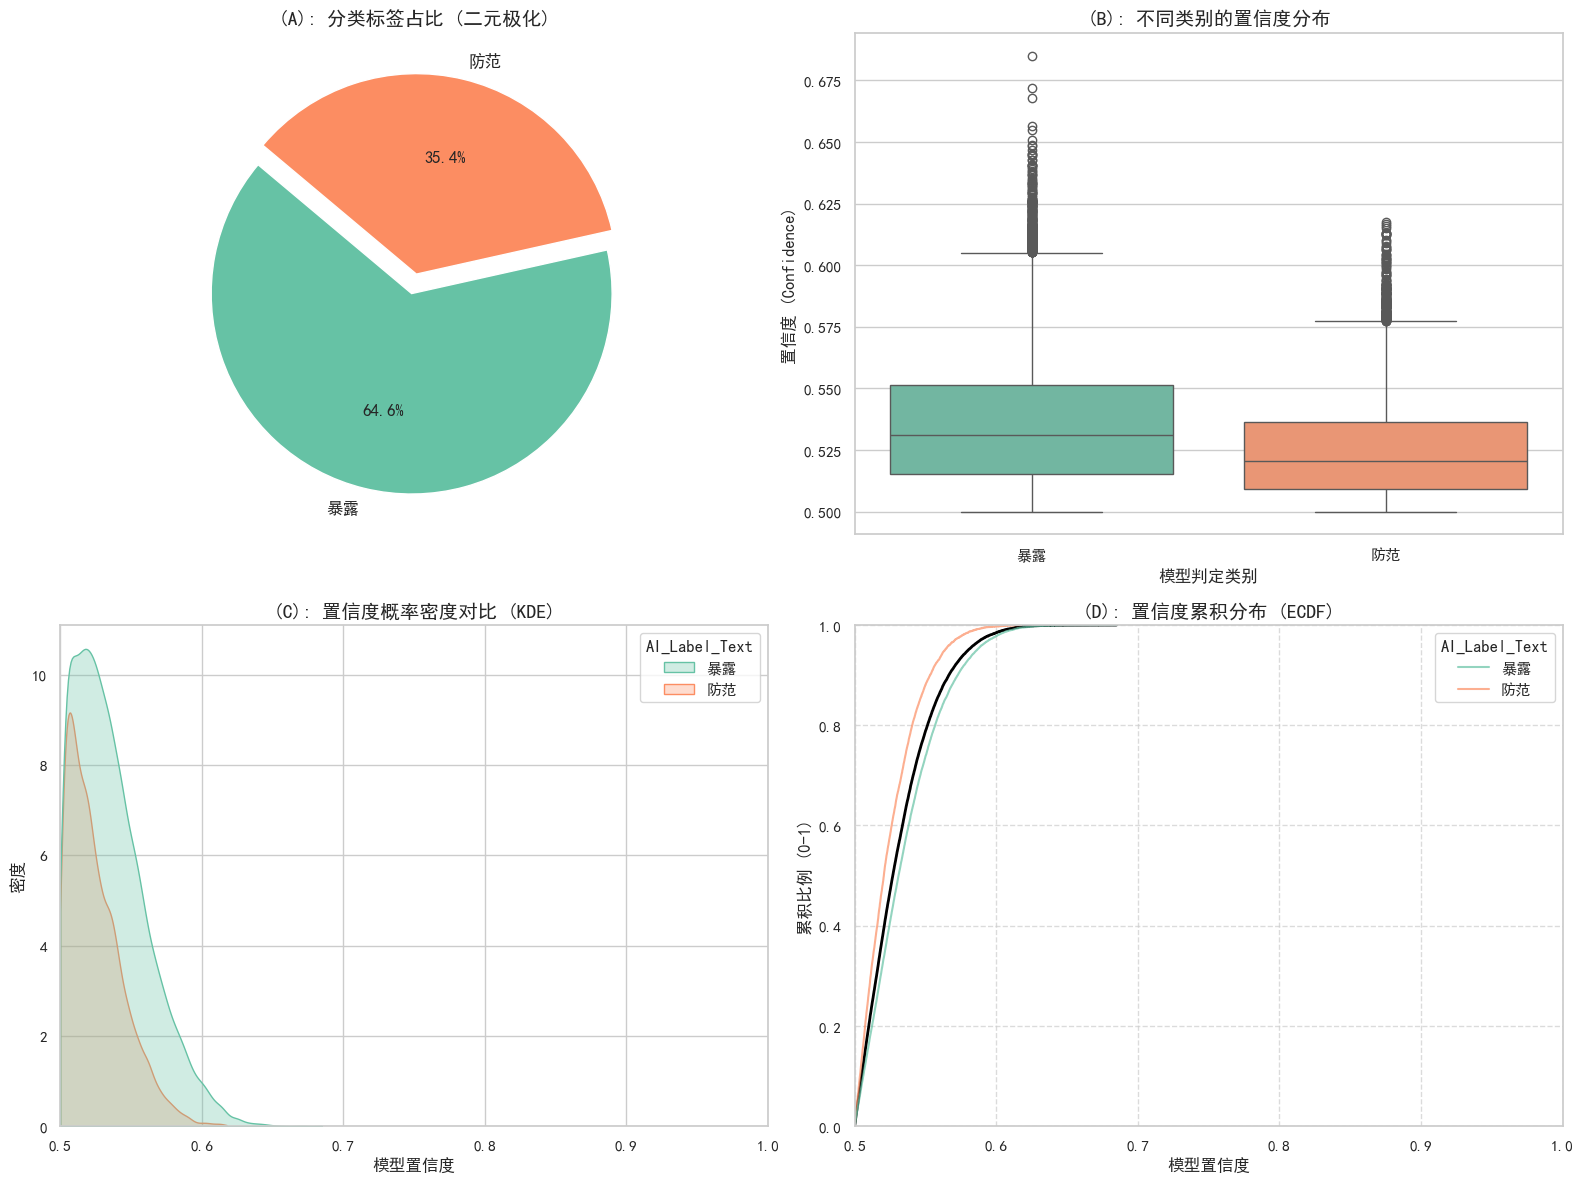

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 预设配置
# ==========================================
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# ==========================================
# 2. 假设 df2 已经加载 (模拟数据用于演示，您直接使用您的 df2 即可)
# ==========================================
# 确保标签是字符串，防止报错
df2['AI_Label_Text'] = df2['AI_Label_Text'].astype(str)

# ==========================================
# 3. 绘图逻辑 (2x2 面板)
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# -------------------------------------------------------
# 图 (A): 标签分布 (改为饼图)
# -------------------------------------------------------
# 先计算各分类的数量
label_counts = df2['AI_Label_Text'].value_counts()

# 绘制饼图
# autopct='%1.1f%%' 显示百分比保留1位小数
# startangle=90 让饼图起始角度旋转90度，通常更好看
# explode 稍微将第一个扇区（通常是占比最大的）分离出来
axes[0, 0].pie(label_counts, 
               labels=label_counts.index, 
               autopct='%1.1f%%', 
               startangle=140, 
               colors=sns.color_palette('Set2'),
               explode=[0.05] * len(label_counts), # 每个块稍微裂开一点
               textprops={'fontsize': 12})

axes[0, 0].set_title('(A): 分类标签占比 (二元极化)', fontsize=14)


# -------------------------------------------------------
# 图 (B): 置信度箱线图
# -------------------------------------------------------
sns.boxplot(data=df2, x='AI_Label_Text', y='AI_Confidence', palette='Set2', ax=axes[0, 1])
axes[0, 1].set_title('(B): 不同类别的置信度分布', fontsize=14)
axes[0, 1].set_xlabel('模型判定类别')
axes[0, 1].set_ylabel('置信度 (Confidence)')


# -------------------------------------------------------
# 图 (C): 置信度核密度估计 (KDE) [参照词典法格式]
# -------------------------------------------------------
sns.kdeplot(data=df2, x='AI_Confidence', hue='AI_Label_Text', 
            fill=True, alpha=0.3, cut=0, palette='Set2', ax=axes[1, 0])

axes[1, 0].set_title('(C): 置信度概率密度对比 (KDE)', fontsize=14)
axes[1, 0].set_xlabel('模型置信度')
axes[1, 0].set_ylabel('密度')
axes[1, 0].set_xlim(0.5, 1.0) # 锁定范围，突显低置信度聚集


# -------------------------------------------------------
# 图 (D): 置信度累积分布 (ECDF) [参照词典法格式]
# -------------------------------------------------------
# 总体曲线 (黑色粗线)
sns.ecdfplot(data=df2, x='AI_Confidence', label='总体置信度', color='black', linewidth=2, ax=axes[1, 1])
# 分类别曲线 (细线)
sns.ecdfplot(data=df2, x='AI_Confidence', hue='AI_Label_Text', palette='Set2', linewidth=1.5, alpha=0.7, ax=axes[1, 1])

axes[1, 1].set_title('(D): 置信度累积分布 (ECDF)', fontsize=14)
axes[1, 1].set_xlabel('模型置信度')
axes[1, 1].set_ylabel('累积比例 (0-1)')
axes[1, 1].grid(True, which='both', linestyle='--', alpha=0.7)
axes[1, 1].set_xlim(0.5, 1.0)


# ==========================================
# 4. 保存与显示
# ==========================================
plt.tight_layout()
plt.savefig('FinBERT_Analysis_Pie_Chart.png', dpi=300)
plt.show()

=== 标签占比 (%) ===
AI_Label_Text
暴露    64.606667
防范    35.393333
Name: proportion, dtype: float64

=== 置信度统计描述 ===
count    30000.000000
mean         0.532086
std          0.024574
min          0.500000
25%          0.512632
50%          0.526934
75%          0.545946
max          0.684875
Name: AI_Confidence, dtype: float64


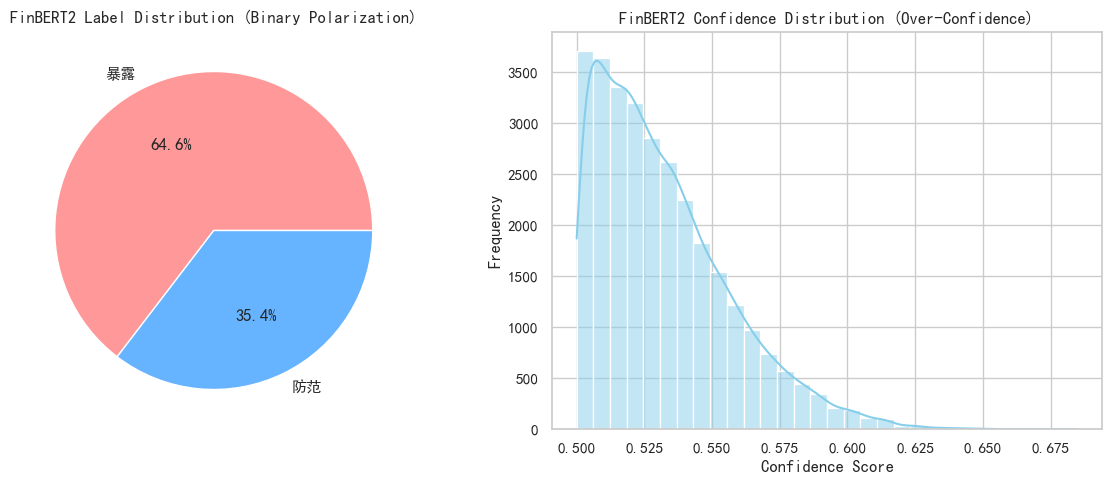

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 分析 AI_Label_Text (标签占比)
label_counts = df2['AI_Label_Text'].value_counts(normalize=True) * 100
print("=== 标签占比 (%) ===")
print(label_counts)

# 2. 分析 AI_Confidence (置信度分布)
confidence_stats = df2['AI_Confidence'].describe()
print("\n=== 置信度统计描述 ===")
print(confidence_stats)

# --- 绘图 ---

plt.figure(figsize=(12, 5))

# 图1：标签分布饼图
plt.subplot(1, 2, 1)
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('FinBERT2 Label Distribution (Binary Polarization)')

# 图2：置信度分布直方图
plt.subplot(1, 2, 2)
sns.histplot(df2['AI_Confidence'], bins=30, kde=True, color='skyblue')
plt.title('FinBERT2 Confidence Distribution (Over-Confidence)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
df1 = pd.read_csv(r'data\climaterisk_LLM_Full_Labeled.csv', encoding='utf-8-sig')
print(df1.columns)

Index(['文件名', '股票代码', '年份', '公司', '句序', '一级分类', '二级分类', '命中关键词', '句子',
       'LLM_Label', 'LLM_Prob_Exposed', 'LLM_Prob_Prevent', 'LLM_Prob_Neutral',
       'LLM_Reason'],
      dtype='object')


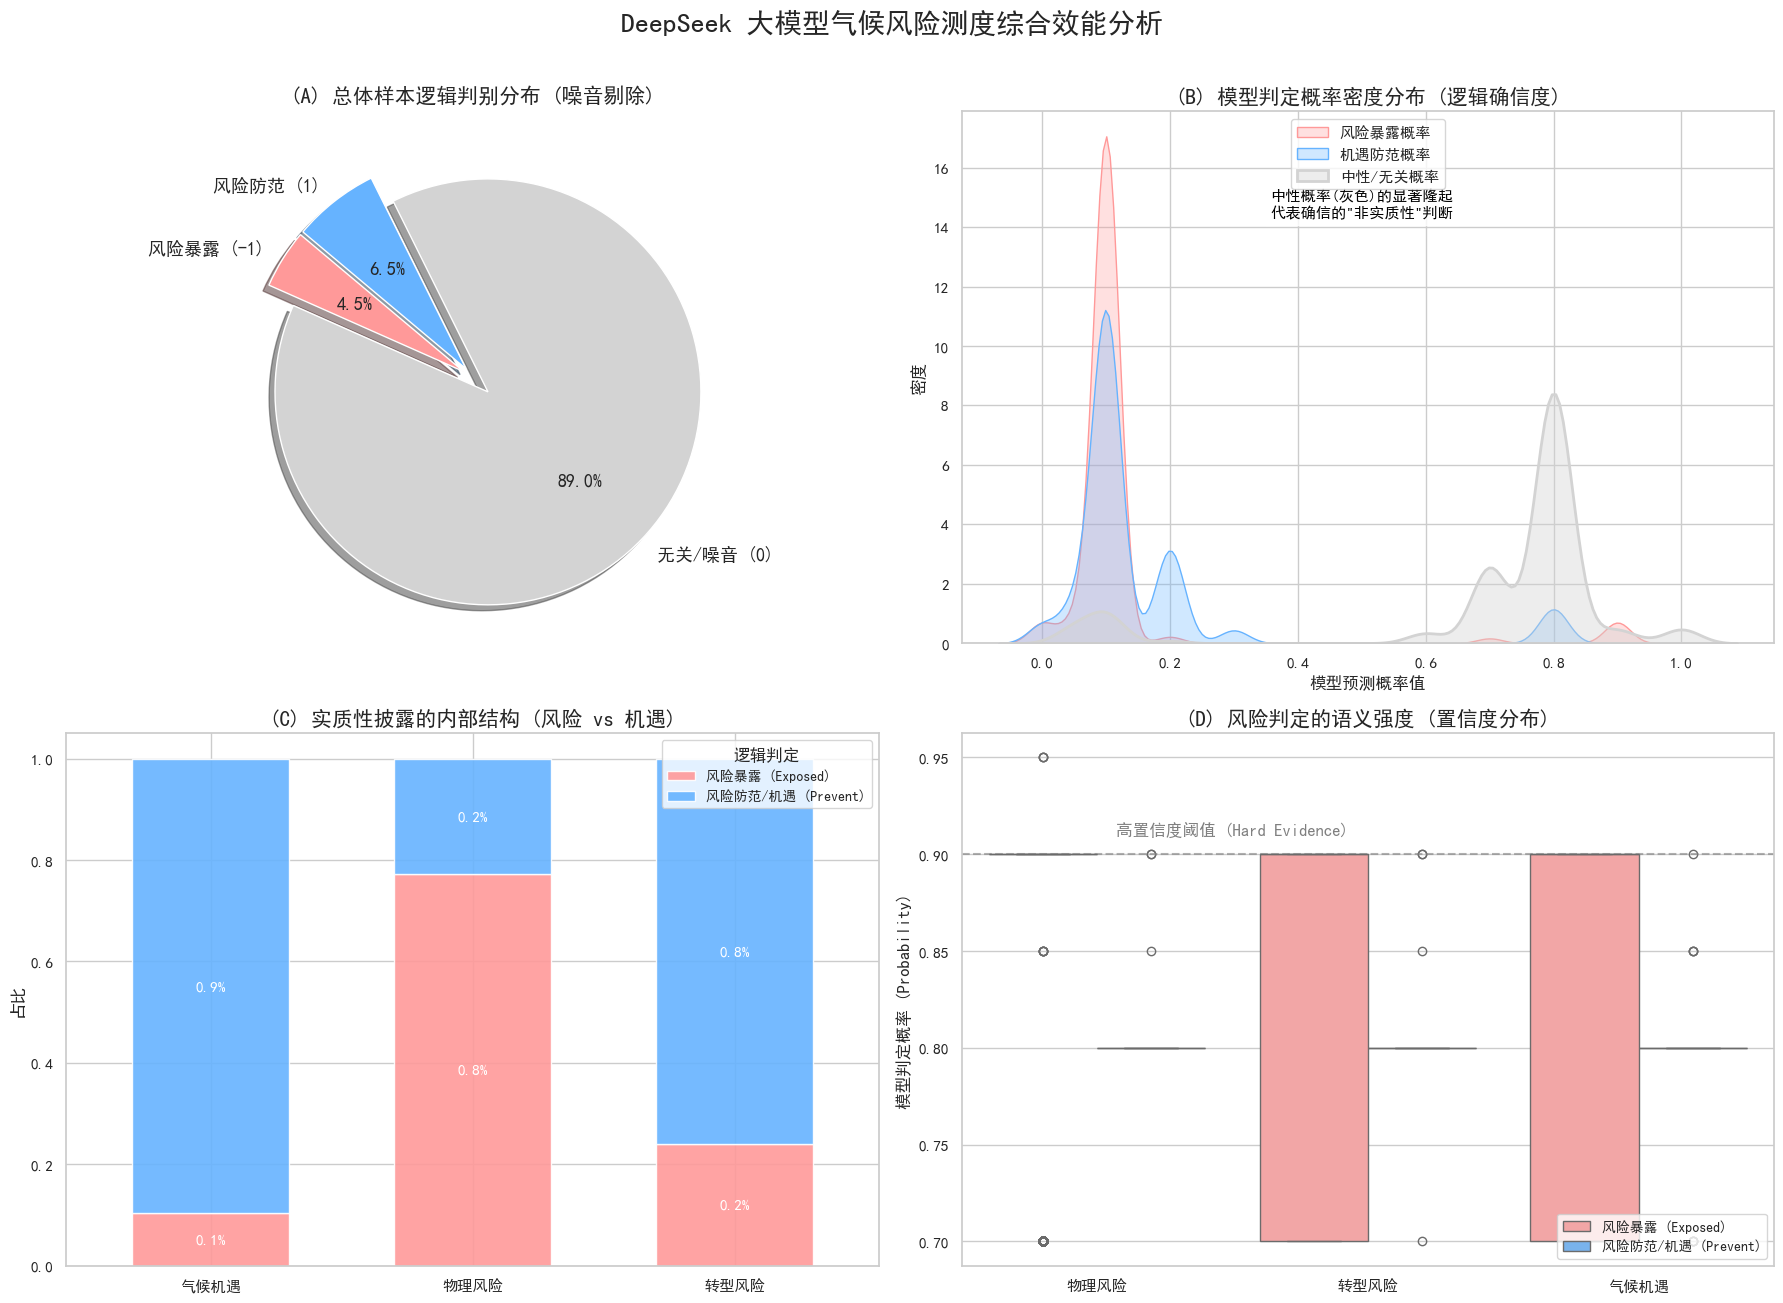

=== 统计摘要 ===
实质性样本量: 3303 (占比 11.0%)

实质性样本分类统计:
Label_Str  风险暴露 (Exposed)  风险防范/机遇 (Prevent)
二级分类                                        
气候机遇                  125               1087
物理风险                 1033                305
转型风险                  181                572


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 0. 数据准备 (请确保 df1 是您的真实结果 DataFrame)
# ==========================================
# 假设 df1 包含列: 'LLM_Label', 'LLM_Prob_Exposed', 'LLM_Prob_Prevent', 'LLM_Prob_Neutral', '二级分类'
# 如果没有置信度列，请先计算：
if 'Confidence' not in df1.columns:
    prob_cols = ['LLM_Prob_Exposed', 'LLM_Prob_Prevent', 'LLM_Prob_Neutral']
    # 确保列存在且为数值
    for col in prob_cols:
        if col not in df1.columns:
            # 如果没有概率列，可能需要根据Label模拟或报错，这里假设存在
            pass
    df1['Confidence'] = df1[prob_cols].max(axis=1)

# ==========================================
# 1. 绘图设置与画布初始化
# ==========================================
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # Windows系统使用SimHei
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # Mac系统使用这个
plt.rcParams['axes.unicode_minus'] = False

# 创建 2x2 的子图布局
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('DeepSeek 大模型气候风险测度综合效能分析', fontsize=20, y=0.96)

# 定义统一的配色方案
colors_map = {-1: '#ff9999', 0: '#d3d3d3', 1: '#66b3ff'} # 红(风险), 灰(无关), 蓝(防范)
palette_sub = ['#ff9999', '#66b3ff'] # 仅用于红蓝对比

# ==========================================
# 子图 A: 总体分类分布 (饼图) - 展示降噪能力
# ==========================================
label_counts = df1['LLM_Label'].value_counts().sort_index()
labels_pie = ['风险暴露 (-1)', '无关/噪音 (0)', '风险防范 (1)']
explode = (0.05, 0.1, 0.05) # 突出中间的噪音部分

# 注意：饼图需要根据 label_counts 的索引来匹配颜色
pie_colors = [colors_map[i] for i in label_counts.index]
# 对应的标签也要对齐
pie_labels = [labels_pie[i+1] for i in label_counts.index] # -1->0, 0->1, 1->2

axes[0, 0].pie(label_counts, labels=pie_labels, autopct='%1.1f%%', startangle=140, 
              colors=pie_colors, explode=explode,
              textprops={'fontsize': 13}, shadow=True)
axes[0, 0].set_title('(A) 总体样本逻辑判别分布 (噪音剔除)', fontsize=15)

# ==========================================
# 子图 B: 概率密度分布 (KDE) - 展示判定逻辑确信度
# ==========================================
sns.kdeplot(df1['LLM_Prob_Exposed'], color=colors_map[-1], fill=True, label='风险暴露概率', alpha=0.3, ax=axes[0, 1])
sns.kdeplot(df1['LLM_Prob_Prevent'], color=colors_map[1], fill=True, label='机遇防范概率', alpha=0.3, ax=axes[0, 1])
sns.kdeplot(df1['LLM_Prob_Neutral'], color=colors_map[0], fill=True, label='中性/无关概率', alpha=0.4, linewidth=2, ax=axes[0, 1])

axes[0, 1].set_title('(B) 模型判定概率密度分布 (逻辑确信度)', fontsize=15)
axes[0, 1].set_xlabel('模型预测概率值')
axes[0, 1].set_ylabel('密度')
axes[0, 1].legend(loc='upper center', fontsize=11)
# 添加注释
axes[0, 1].text(0.5, axes[0, 1].get_ylim()[1]*0.8, '中性概率(灰色)的显著隆起\n代表确信的"非实质性"判断', 
             fontsize=11, color='black', ha='center', bbox=dict(facecolor='white', alpha=0.8))

# ==========================================
# 数据准备: 筛选实质性样本 (用于子图 C 和 D)
# ==========================================
df_relevant = df1[df1['LLM_Label'] != 0].copy()
label_map_str = {-1: '风险暴露 (Exposed)', 1: '风险防范/机遇 (Prevent)'}
df_relevant['Label_Str'] = df_relevant['LLM_Label'].map(label_map_str)

# 提取用于绘图的概率值 (Relevant Probability)
def get_relevant_prob(row):
    if row['LLM_Label'] == -1:
        return row['LLM_Prob_Exposed']
    elif row['LLM_Label'] == 1:
        return row['LLM_Prob_Prevent']
    return np.nan
df_relevant['Relevant_Prob'] = df_relevant.apply(get_relevant_prob, axis=1)

# ==========================================
# 子图 C: 实质性样本结构 (堆叠柱状图) - 展示披露策略
# ==========================================
stats_structure = pd.crosstab(df_relevant['二级分类'], df_relevant['Label_Str'])
# 归一化为百分比
stats_norm = stats_structure.div(stats_structure.sum(axis=1), axis=0)
# 调整列顺序，确保红色在下，蓝色在上 (符合视觉习惯)
if '风险暴露 (Exposed)' in stats_norm.columns:
    cols_order = ['风险暴露 (Exposed)', '风险防范/机遇 (Prevent)']
    # 确保列存在，防止某一类缺失
    cols_order = [c for c in cols_order if c in stats_norm.columns]
    stats_norm = stats_norm[cols_order]

stats_norm.plot(kind='bar', stacked=True, color=palette_sub, alpha=0.9, ax=axes[1, 0], width=0.6)

axes[1, 0].set_title('(C) 实质性披露的内部结构 (风险 vs 机遇)', fontsize=15)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('占比')
axes[1, 0].legend(title='逻辑判定', loc='upper right', fontsize=10)
axes[1, 0].tick_params(axis='x', rotation=0) # 横轴文字不倾斜

# 在柱子上标数值
for c in axes[1, 0].containers:
    axes[1, 0].bar_label(c, fmt='%.1f%%', label_type='center', color='white', fontsize=11, weight='bold')

# ==========================================
# 子图 D: 语义强度箱线图 (Boxplot) - 展示信息硬度
# ==========================================
sns.boxplot(x='二级分类', y='Relevant_Prob', hue='Label_Str', data=df_relevant, 
            palette=palette_sub, ax=axes[1, 1], order=['物理风险', '转型风险', '气候机遇'])

axes[1, 1].set_title('(D) 风险判定的语义强度 (置信度分布)', fontsize=15)
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('模型判定概率 (Probability)')
# 画一条高置信度辅助线
axes[1, 1].axhline(0.9, ls='--', color='gray', alpha=0.6)
axes[1, 1].text(0.5, 0.91, '高置信度阈值 (Hard Evidence)', color='gray', ha='center')
axes[1, 1].legend(loc='lower right', fontsize=10)

# ==========================================
# 3. 布局调整与显示
# ==========================================
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 留出标题空间
plt.show()

# ==========================================
# 4. 输出关键统计量 (用于写作)
# ==========================================
print("=== 统计摘要 ===")
n_clean = len(df_relevant)
print(f"实质性样本量: {n_clean} (占比 {n_clean/len(df1):.1%})")
print("\n实质性样本分类统计:")
print(stats_structure)